<a href="https://colab.research.google.com/github/JLuceroVasquez/challenge-telecom-x-latam-parte-2/blob/main/TelecomX-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Desafío Telecom parte 2**

In [103]:
#Para la manipulación de datos
import pandas as pd
import numpy as np

#Para visualización de datos y resultados
import matplotlib.pyplot as plt
import seaborn as sns

#Para la selección de features
from statsmodels.tools.tools import add_constant #Para añadir una constante a mis datos, de forma que pueda calcular el VIF de cada feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif #Para calcular el VIF de cada feature
from sklearn.inspection import permutation_importance #Para calcular la importancia de permutación promedio de los features

#Para transformación de predictoras
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler #Normalización estándar para el modelo de Regresión logística

#Para división de datos en entrenamiento y evaluación, entrenamiento y optimización de modelos ML
from sklearn.model_selection import train_test_split #División de datos en conjunto de entrenamiento y prueba
from sklearn.model_selection import StratifiedKFold, cross_validate #Entrenamiento y validación cruzada del Modelos ML
from sklearn.model_selection import GridSearchCV #Para optimización de los hiperparámetros de modelos ML

#Para el balanceo de categorías en la variable Y
from imblearn.over_sampling import SMOTE #Técnica de oversampling SMOTE
from imblearn.under_sampling import NearMiss #Técnica de undersampling NearMiss
from imblearn.combine import SMOTEENN #Técnica que combina el método oversampling SMOTE y undersampling ENN
from imblearn.pipeline import Pipeline as imbpipeline #Para crear un pipeline (secuencia de pasos) que permita entrenar un modelo con datos balanceados, y validarlo por separado con datos desbalanceados

#Modelos ML
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Para la evaluación de modelos ML: Matriz de confusión
from sklearn.metrics import confusion_matrix #Para obtener los valores de la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay #Para visualizar la matriz de confusión
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Para el cálculo de métricas que cuantifiquen el error tipo 1 y 2 de la matriz de confusión

#Para la evaluación de modelos ML: Curva ROC
from sklearn.metrics import RocCurveDisplay #Para visualizar la curva ROC

#Para la evaluación de modelos ML: Curva de precisión x sensibilidad
from sklearn.metrics import PrecisionRecallDisplay #Para visualizar la curva de precisión x sensibilidad

#Para la evaluación de modelos ML: Informe de clasificación
from sklearn.metrics import classification_report #Para visualizar las métricas de precisión, recall y F1 por cada categoría, y sus promedios

##**Preparación de los datos**

###*Extracción del archivo tratado*

In [61]:
'''
import chardet
with open('/content/TelecomX-data.csv', 'rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)
'''

"\nimport chardet\nwith open('/content/TelecomX-data.csv', 'rb') as f:\n  diccionario = chardet.detect(f.read())\n  encode = diccionario['encoding']\n\nprint(encode)\n"

In [62]:
url = 'https://github.com/JLuceroVasquez/challenge-telecom-x-latam-parte-2/raw/refs/heads/main/TelecomX-data.csv'
datos = pd.read_csv(url, encoding='utf-8')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customerid             7043 non-null   object 
 1   churn                  7043 non-null   object 
 2   gender                 7043 non-null   object 
 3   seniorcitizen          7043 non-null   bool   
 4   partner                7043 non-null   bool   
 5   dependents             7043 non-null   bool   
 6   tenure                 7043 non-null   int64  
 7   phoneservice           7043 non-null   bool   
 8   multiplelines          7043 non-null   bool   
 9   internetservice        7043 non-null   object 
 10  onlinesecurity         7043 non-null   bool   
 11  onlinebackup           7043 non-null   bool   
 12  deviceprotection       7043 non-null   bool   
 13  techsupport            7043 non-null   bool   
 14  streamingtv            7043 non-null   bool   
 15  stre

###*Tipado de columnas*

In [63]:
#Convertir las columnas categóricas a tipo category
datos = datos.astype({col: 'category' for col in datos.select_dtypes([object, bool]).columns})
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   customerid             7043 non-null   category
 1   churn                  7043 non-null   category
 2   gender                 7043 non-null   category
 3   seniorcitizen          7043 non-null   category
 4   partner                7043 non-null   category
 5   dependents             7043 non-null   category
 6   tenure                 7043 non-null   int64   
 7   phoneservice           7043 non-null   category
 8   multiplelines          7043 non-null   category
 9   internetservice        7043 non-null   category
 10  onlinesecurity         7043 non-null   category
 11  onlinebackup           7043 non-null   category
 12  deviceprotection       7043 non-null   category
 13  techsupport            7043 non-null   category
 14  streamingtv            7043 non-null   c

###*Eliminación de Columnas Irrelevantes*
Se eliminaron las columnas `customerid` y `servicios_contratados`. Debido a que:
* **`customerid`**: No aporta información relevante para predecir la variable de respuesta churn.
* **`servicios_contratados`**: Posee información redundante que está implicita en otras columnas que detallan si el cliente tiene contratado o no un servicio en específico.

In [64]:
datos.drop(columns=['customerid', 'servicios_contratados'], inplace=True)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   churn             7043 non-null   category
 1   gender            7043 non-null   category
 2   seniorcitizen     7043 non-null   category
 3   partner           7043 non-null   category
 4   dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   phoneservice      7043 non-null   category
 7   multiplelines     7043 non-null   category
 8   internetservice   7043 non-null   category
 9   onlinesecurity    7043 non-null   category
 10  onlinebackup      7043 non-null   category
 11  deviceprotection  7043 non-null   category
 12  techsupport       7043 non-null   category
 13  streamingtv       7043 non-null   category
 14  streamingmovies   7043 non-null   category
 15  contract          7043 non-null   category
 16  paperlessbilling  7043 n

###*Eliminación de registro con datos nulos*
La columna `charges_total` era la única con datos nulos, un total de 11. Tenía dos opciones:
* Eliminar los 11 registros.
* Calcular el valor de los 11 registros a partir de la multiplicación de las variables `tenure x 12  x charges_monthly`.
Se eligió eliminar los 11 registros, pues aún quedaban 7032 registros para usar. Y además, no era seguro que la multiplicación produzca el valor correcto de `charges_total`. Puesto que a lo largo del tiempo que el cliente estaba en la empresa, el monto mensual cobrado podría haber variado.

In [65]:
#Conteo de registro con datos nulos
datos.isnull().sum()

,0
churn,0
gender,0
seniorcitizen,0
partner,0
dependents,0
tenure,0
phoneservice,0
multiplelines,0
internetservice,0
onlinesecurity,0


In [66]:
#Visualizamos los registros con datos nulos en la columna 'charges_total'
registros_nulos = datos[datos.isnull().any(axis=1)]
registros_nulos

,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges_monthly,charges_total,cuenta_diaria
945,No,Femenino,False,True,True,0,False,False,DSL,True,...,True,True,True,False,Dos años,False,Tarjeta de crédito (automático),56.05,NaN,1.868333
1731,No,Femenino,False,True,True,0,True,False,No,False,...,False,False,False,False,Dos años,False,Cheque por correo,20.00,NaN,0.666667
1906,No,Masculino,False,False,True,0,True,True,DSL,True,...,False,True,False,False,Dos años,True,Transferencia bancaria (automático),61.90,NaN,2.063333
2025,No,Masculino,False,True,True,0,True,False,No,False,...,False,False,False,False,Un año,True,Cheque por correo,19.70,NaN,0.656667
2176,No,Masculino,False,False,True,0,True,False,No,False,...,False,False,False,False,Dos años,False,Cheque por correo,20.25,NaN,0.675000
2250,No,Masculino,False,True,True,0,True,True,No,False,...,False,False,False,False,Dos años,False,Cheque por correo,25.35,NaN,0.845000
2855,No,Femenino,False,True,True,0,True,True,DSL,False,...,True,True,True,False,Dos años,False,Cheque por correo,73.35,NaN,2.445000
3052,No,Masculino,False,True,True,0,True,True,No,False,...,False,False,False,False,Dos años,False,Cheque por correo,25.75,NaN,0.858333
3118,No,Femenino,False,True,True,0,False,False,DSL,True,...,True,True,True,False,Dos años,True,Transferencia bancaria (automático),52.55,NaN,1.751667
4054,No,Femenino,False,True,True,0,True,False,DSL,True,...,True,False,True,True,Dos años,False,Cheque por correo,80.85,NaN,2.695000


In [67]:
#Eliminamos los 11 registros con datos nulos en la columna 'charges_total'
datos.dropna(subset=['charges_total'], axis=0, how='any', inplace=True)
datos.isnull().sum()

,0
churn,0
gender,0
seniorcitizen,0
partner,0
dependents,0
tenure,0
phoneservice,0
multiplelines,0
internetservice,0
onlinesecurity,0


###*Encoding*
Antes de realizar la transformación OneHot, se verificó si las variables categóricas contenían demasiados valores únicos que debían unirse bajo una misma categoría. La única variable que parecía sospechosa fue `internetservice`, sin embargo, al revisar sus valores únicos me encontré conforme con las categorías y no realice ninguna corrección.

Luego, se realizó la transformación OneHot configurando el parámetro `drop='if_binary'` que elimina la primera categoría de la variable según el **orden interno** de categorías que maneja el encoder.

Ese orden se controla con el parámetro `categories`. Si está en "`auto`" (el valor por defecto), el encoder:

1. Detecta automáticamente las categorías.

2. Las ordena alfabéticamente (para str) o de menor a mayor (para int o bool). Entonces:

    * "femenino" → 0, "masculino" → 1.
    * False → 0, True → 1.

OneHotEncoder elimina una de ellas para evitar **colinealidad** (la famosa “trampa de las variables ficticias” en **regresión**). Esto es necesario, porque se empleará el modelo de regresión logística.

In [68]:
#Se verifica la cantidad de categorías en las variables tipo 'category'
datos.describe(include='category')

,churn,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,2,2,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4
top,No,Masculino,False,False,False,True,False,Fibra óptica,False,False,False,False,False,False,Mes a mes,True,Cheque electrónico
freq,5163,3549,5890,3639,4933,6352,4065,3096,5017,4607,4614,4992,4329,4301,3875,4168,2365


In [69]:
#Se visualizan los 3 valores únicos de la columna 'internetservice'
datos['internetservice'].unique()

['DSL', 'Fibra óptica', 'No']
Categories (3, object): ['DSL', 'Fibra óptica', 'No']

In [70]:
#Se crea una lista con el nombre de las columnas categóricas.
columnas_categoricas = datos.select_dtypes(include='category').columns
columnas_categoricas

Index(['churn', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod'],
      dtype='object')

In [71]:
#Se crea la regla para la transformación de columnas.
one_hot = make_column_transformer((OneHotEncoder(drop='if_binary', handle_unknown='ignore'),#En columna con dos categorias, se establece la primera como cero y la segunda como 1. Si se detectan categorías desconocidas durante la transformación, se ignoran y asigna un valor de cero.
                                   columnas_categoricas),
                                  remainder='passthrough',#Las columnas no nombradas en el transformador, se mantienen.
                                  sparse_threshold=0, #Proporción mínima de datos diferente de ceros que, de no superarse, genera una matriz sparse para optimizar la memoria y eficiencia computacional.
                                  force_int_remainder_cols=False) #Establecer en Falso mantiene los nombres de las columnas transformadas, en lugar de convertirlas en enteros.

#Se crea un array que contiene los datos de las variables explicativas transformadas.
datos_transformados = one_hot.fit_transform(datos)

#Se crea el dataframe con el array y nombre de las variables explicativas transformadas.
datos_transformados = pd.DataFrame(data= datos_transformados, columns=one_hot.get_feature_names_out())
datos_transformados.head()

,onehotencoder__churn_Si,onehotencoder__gender_Masculino,onehotencoder__seniorcitizen_1.0,onehotencoder__partner_1.0,onehotencoder__dependents_1.0,onehotencoder__phoneservice_1.0,onehotencoder__multiplelines_1.0,onehotencoder__internetservice_DSL,onehotencoder__internetservice_Fibra óptica,onehotencoder__internetservice_No,...,onehotencoder__contract_Un año,onehotencoder__paperlessbilling_1.0,onehotencoder__paymentmethod_Cheque electrónico,onehotencoder__paymentmethod_Cheque por correo,onehotencoder__paymentmethod_Tarjeta de crédito (automático),onehotencoder__paymentmethod_Transferencia bancaria (automático),remainder__tenure,remainder__charges_monthly,remainder__charges_total,remainder__cuenta_diaria
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,9.0,65.6,593.30,2.186667
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,1.996667
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,2.463333
3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,3.266667
4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,83.9,267.40,2.796667


##**Correlación y selección de variables**

###*Análisis de correlación*
Nuestro foco es entender qué variables tienen mayor correlación con la variable objetivo `"Evasión"`. Filtrando por las variables más relevantes, obtenemos un subconjunto manejable.

Por eso, se generó un gráfico que muestra **correlaciones ≥ 0.1** (o ≤ -0.1) con la variable objetivo `Churn_Si`. Fueron estas variables las seleccionadas para la siguiente etapa.

In [72]:
#Matriz de correlacion
corr = datos_transformados.corr()

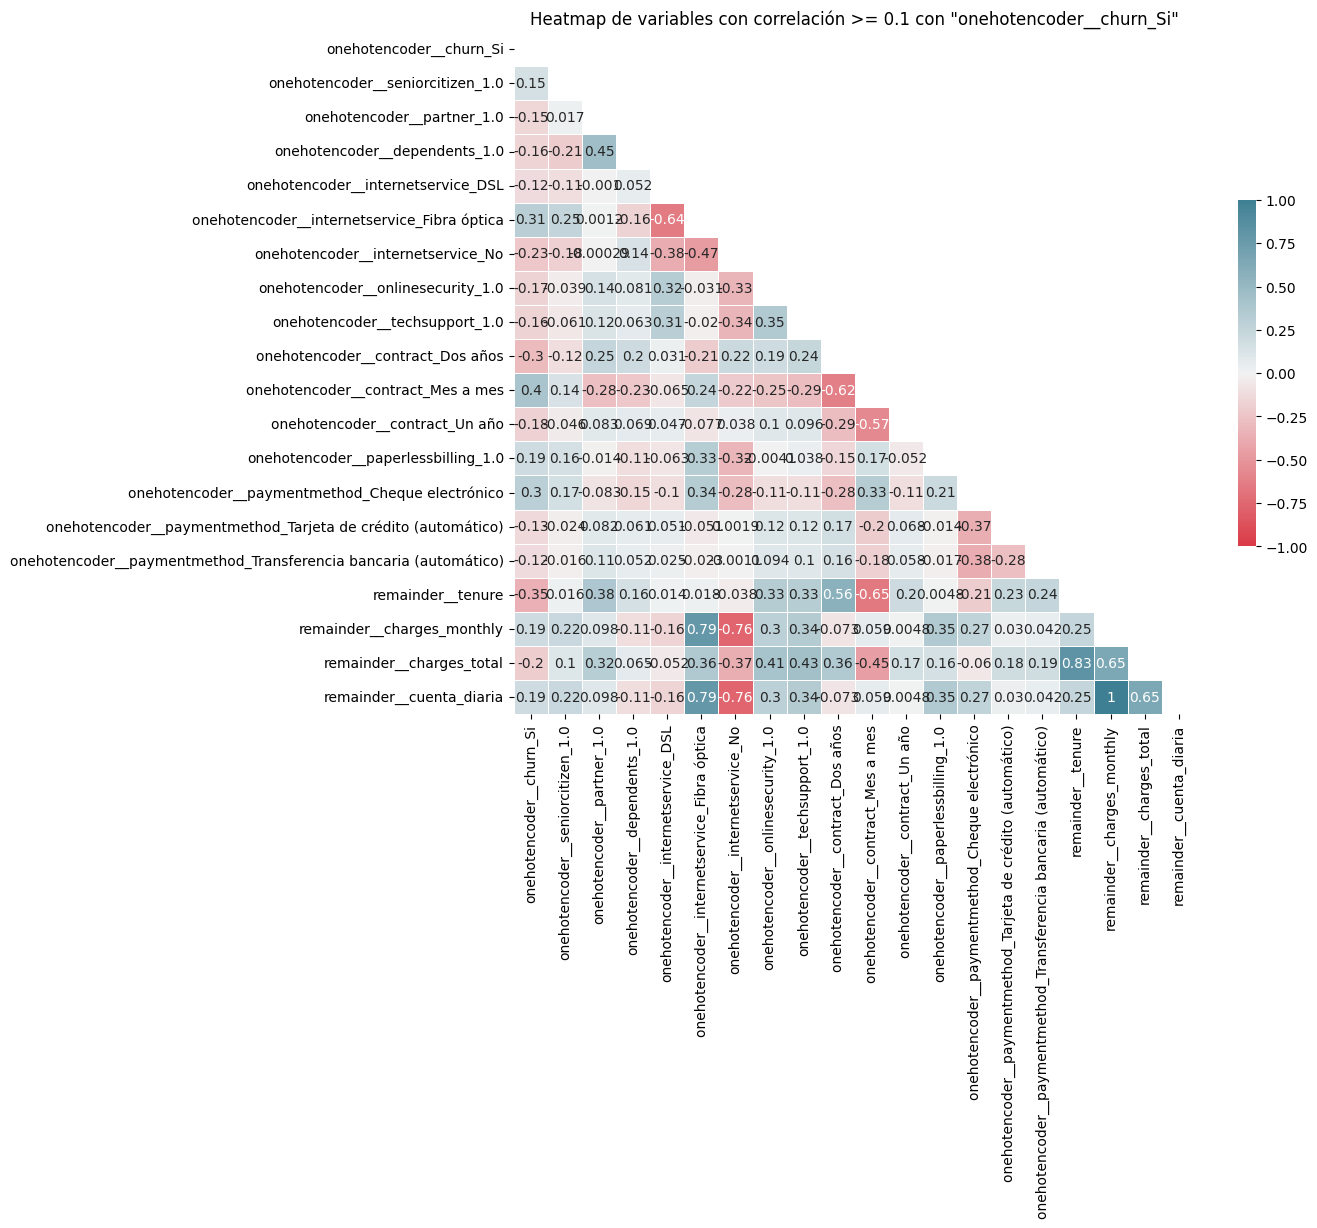

In [73]:
#Mapa de calor de las correlaciones mayores a 0.1
y = 'onehotencoder__churn_Si'

# Definir el umbral mínimo de correlación absoluta para selección
umbral = 0.1

# Filtrar variables que tengan correlación absoluta >= umbral con la variable objetivo
# Esto crea una lista con las variables relevantes
features_relevantes = corr.index[abs(corr[y]) >= umbral].tolist()

# Crear una matriz de correlación solo con las variables seleccionadas
corr_filtrada = corr.loc[features_relevantes, features_relevantes]

# Generar una máscara para ocultar el triángulo superior de la matriz (incluida la diagonal)
mascara = np.zeros_like(corr_filtrada, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Graficar el heatmap con la máscara aplicada para mejor visualización
plt.figure(figsize=(11,9))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_filtrada, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.title(f'Heatmap de variables con correlación >= {umbral} con "{y}"')
plt.show()

In [74]:
#Dataframe con los features seleccionados
datos_seleccionados = datos_transformados[features_relevantes]

###*Análisis de la Factor de Inflación de la Varianza (VIF)*
El VIF ayuda a detectar la presencia de multicolinealidad entre variables independientes.

Generalmente, **VIF > 5** o **VIF > 10** indica que la variable está colineal con otras y puede ser eliminada.

✅ **Resumen general del análisis VIF**

| Rango de VIF       | Interpretación                |
| ------------------ | ----------------------------- |
| VIF ≈ 1            | Sin multicolinealidad         |
| 1 < VIF < 5        | Baja (aceptable)              |
| 5 ≤ VIF < 10       | Moderada (vigilar)            |
| VIF ≥ 10           | Alta (¡atención!)             |
| VIF = ∞ (infinito) | Multicolinealidad perfecta ⚠️ |

En mi caso, verifiqué que las variables seleccionadas no tengan un VIF>5 a fin de reducir la multicolinealidad que pueda afectar la importancia de los coeficientes de mi modelo de regresión logística y la [importancia de permutación](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) de mis variables (esta métrica se usará más adelante).

####Cálculo VIF: Variables correlacionadas con Y > umbral

In [75]:
#Se filtra el df con los datos_transformados a fin de considerar solo las variables predictoras
X = datos_seleccionados.drop(columns=['onehotencoder__churn_Si'])
X_const = add_constant(X)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [vif(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
9,onehotencoder__contract_Dos años,inf
6,onehotencoder__internetservice_No,inf
5,onehotencoder__internetservice_Fibra óptica,inf
4,onehotencoder__internetservice_DSL,inf
11,onehotencoder__contract_Un año,inf
10,onehotencoder__contract_Mes a mes,inf
17,remainder__charges_monthly,inf
19,remainder__cuenta_diaria,inf
18,remainder__charges_total,10.418400
16,remainder__tenure,7.499214


In [76]:
# Definir el umbral máximo de VIF para selección 1
umbral = 15

# Filtrar variables que tengan VIF absoluta < umbral
# Esto crea una lista con las variables relevantes
features_relevantes = vif_data.feature[vif_data["VIF"] < umbral].tolist()
features_relevantes

['const',
 'onehotencoder__seniorcitizen_1.0',
 'onehotencoder__partner_1.0',
 'onehotencoder__dependents_1.0',
 'onehotencoder__onlinesecurity_1.0',
 'onehotencoder__techsupport_1.0',
 'onehotencoder__paperlessbilling_1.0',
 'onehotencoder__paymentmethod_Cheque electrónico',
 'onehotencoder__paymentmethod_Tarjeta de crédito (automático)',
 'onehotencoder__paymentmethod_Transferencia bancaria (automático)',
 'remainder__tenure',
 'remainder__charges_total']

####Cálculo VIF: Variables seleccionadas

In [77]:
X_const = X_const[features_relevantes]

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [vif(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
vif_data.sort_values(by='VIF', ascending=False, inplace=True)
vif_data

,feature,VIF
0,const,7.428273
11,remainder__charges_total,4.217051
10,remainder__tenure,3.827816
7,onehotencoder__paymentmethod_Cheque electrónico,1.865721
9,onehotencoder__paymentmethod_Transferencia ban...,1.728463
8,onehotencoder__paymentmethod_Tarjeta de crédit...,1.716053
2,onehotencoder__partner_1.0,1.460167
3,onehotencoder__dependents_1.0,1.367093
5,onehotencoder__techsupport_1.0,1.321078
4,onehotencoder__onlinesecurity_1.0,1.282751


In [82]:
#Dataframe con los features seleccionados
features_relevantes = vif_data["feature"][1:].tolist() #Se omite el primer elemento, que corresponde a la constante.

datos_seleccionados = datos_transformados[features_relevantes]
datos_seleccionados.shape[1]

11

##**Modelo predictivo**

###*Separación de datos*

In [83]:
X = datos_seleccionados
y = datos_transformados['onehotencoder__churn_Si']

In [90]:
#Se dividió los datos en conjunto de entrenamiento y de prueba. El parametro stratify asegura que la proporción de clases de "y" se mantenga en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

###*Insumos para la evaluación de modelos*

In [88]:
#Se define una función para calcular los intervalos de confianza a partir de un diccionario de métricas.
def intervaloconfianza(resultado, metrica):
  score_name = f'test_{metrica}'
  metrica_promedio = resultado[score_name].mean()
  metrica_std = resultado[score_name].std()
  return f'Intervalo del confianza para {metrica} es: ({(metrica_promedio - 2*metrica_std):.4f};{min(metrica_promedio + 2*metrica_std,1):.4f})'

In [89]:
#Se crea una lista con los nombres predefinidos de las métricas que servirán para evaluar los modelos
metricas = ['accuracy', 'recall', 'precision', 'f1']

###*Baseline: DummyClassifier*
En este caso, este predictor bobo siempre predice la clase más frecuente que es 0 correspondiente a que el cliente no hace `churn`. Por tanto no realizará prediccionas de 1, y no se podrá calcular métricas como **precision**, **recall** o **F1**. Por eso, solo se calculó la métrica **accuracy**.

In [92]:
y_train.value_counts(normalize=True)

,proportion
onehotencoder__churn_Si,
0.0,0.734254
1.0,0.265746


In [104]:
modelo_dummy = DummyClassifier(strategy='most_frequent')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_resultados = cross_validate(estimator = modelo_dummy, X=X_train, y=y_train, cv=skf, scoring={'accuracy':'accuracy'})
intervaloconfianza(cv_resultados,'accuracy')

'Intervalo del confianza para accuracy es: (0.7334;0.7351)'

###*Modelo 1: Regresión logística*

In [105]:
#Se escala las variables para que todas sigan un distribución de media 0 y std 1. Esto es necesario en la regresión logística.
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

modelo_lr = LogisticRegression(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in metricas:
  cv_resultados = cross_validate(estimator = modelo_lr, X=X_train_std, y=y_train, cv=skf, scoring={i:i})
  print(intervaloconfianza(cv_resultados,i))

Intervalo del confianza para accuracy es: (0.7709;0.8033)
Intervalo del confianza para recall es: (0.4036;0.4924)
Intervalo del confianza para precision es: (0.6013;0.6837)
Intervalo del confianza para f1 es: (0.4857;0.5698)


###*Modelo 2: Random Forest Classifier*

In [106]:
modelo_rf = RandomForestClassifier(max_depth=3, random_state=5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in metricas:
  cv_resultados = cross_validate(estimator = modelo_rf, X=X_train, y=y_train, cv=skf, scoring={i:i})
  print(intervaloconfianza(cv_resultados,i))

Intervalo del confianza para accuracy es: (0.7574;0.7797)
Intervalo del confianza para recall es: (0.2086;0.2760)
Intervalo del confianza para precision es: (0.6215;0.7432)
Intervalo del confianza para f1 es: (0.3168;0.3979)


###*Elección del mejor método de balanceo de clases*
Debido a que el modelo de Regresión logística obtuvo los mejores intervalos de confianza en todas las métricas, pero en especial la que es de interés para TelecomX que sería el recall para la predicción de clientes que en efecto hacen churn, es el modelo que se optimizará en adelante mediante el balanceo de clases.

Para ello, se probarán tres métodos de balance:
* SMOTE del tipo oversampling.
* NearMiss del tipo undersampling.
* SMOTEENN del que combina oversampling y undersampling.

A partir de los resultados, se escogió el método SMOTEEN que produce el intervalo de la métrica **recall** con los valores más altos.

In [108]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_lr = LogisticRegression(random_state=42)
pipeline = imbpipeline(steps=[('normalizacion', StandardScaler()),
                              ('balanceo oversampling', SMOTE(random_state=42)),
                              ('modelo', modelo_lr)]) #Solo se contruye el estimador

#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in metricas:
  cv_resultados = cross_validate(estimator = pipeline, X=X_train, y=y_train, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará SMOTE unicamente durante el entrenamiento.
  print(intervaloconfianza(cv_resultados, i))

Intervalo del confianza para accuracy es: (0.6960;0.7635)
Intervalo del confianza para recall es: (0.7494;0.8316)
Intervalo del confianza para precision es: (0.4569;0.5333)
Intervalo del confianza para f1 es: (0.5691;0.6485)


In [109]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_lr = LogisticRegression(random_state=42)
pipeline = imbpipeline(steps=[('normalizacion', StandardScaler()),
                              ('balanceo undersampling', NearMiss(version=3)),
                              ('modelo', modelo_lr)]) #Solo se contruye el estimador

#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in metricas:
  cv_resultados = cross_validate(estimator = pipeline, X=X_train, y=y_train, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará NearMiss unicamente durante el entrenamiento.
  print(intervaloconfianza(cv_resultados, i))

Intervalo del confianza para accuracy es: (0.7021;0.7782)
Intervalo del confianza para recall es: (0.6775;0.7660)
Intervalo del confianza para precision es: (0.4569;0.5601)
Intervalo del confianza para f1 es: (0.5483;0.6447)


In [107]:
#Creación de un pipeline para entrenar el modelo de arbol con datos balanceados, para que aprenda de ambas clases
modelo_lr = LogisticRegression(random_state=42)
pipeline = imbpipeline(steps=[('normalizacion', StandardScaler()),
                              ('balanceo mixto', SMOTEENN(random_state=42)),
                              ('modelo', modelo_lr)]) #Solo se contruye el estimador

#Informe de métricas de la validación cruzada para el conjunto de datos desbalanceados, para obtener resultados más realistas
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in metricas:
  cv_resultados = cross_validate(estimator = pipeline, X=X_train, y=y_train, cv=skf, scoring={i:i})#Se ejecuta el pipeline que usará SMOTENN unicamente durante el entrenamiento.
  print(intervaloconfianza(cv_resultados, i))

Intervalo del confianza para accuracy es: (0.6854;0.7506)
Intervalo del confianza para recall es: (0.7657;0.8337)
Intervalo del confianza para precision es: (0.4461;0.5178)
Intervalo del confianza para f1 es: (0.5650;0.6377)


##**Optimización del modelo escogido**

###*Entrenamiento del mejor predictor*

In [110]:
pipeline = imbpipeline(steps=[('normalizacion', StandardScaler()),
                              ('balanceo mixto', SMOTEENN(random_state=42)),
                              ('modelo', modelo_lr)])
modelo = pipeline.fit(X_train, y_train)

###*Ordenar los features según importancia de permutación*
La [**importancia total de la permutación**](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) supera las limitaciones de la **importancia de las características basadas en impurezas**:

* No tienen un sesgo hacia características de alta cardinalidad.
* No depende de cómo se entrenó el modelo, sino de cómo afecta cada característica al rendimiento del modelo en datos nuevos (no vistos durante el entrenamiento).

Aún así, el cálculo de la **importancia total de la permutación** es más **costoso**. Cada característica se baraja n veces y el modelo se utiliza para realizar predicciones sobre los datos permutados y observar la disminución del rendimiento.

Además, esta métrica es suceptible a mostrar resultados donde ninguna variable predictora (feature) es importante cuante existe **multicolinealidad**. Sin embargo, se logró reducir la multicolinealidad al seleccionar features con un factor de inflación de la varianza (vif) menor a 5.

In [112]:
#Se crea una lista con el nombre de los estimadores
nombres_estimadores = X_train.columns

#Se calcula la importancia de cada estimador tras permutarlo 10 y observar la caida en la métrica recall, obteniendo un diccionario con los resultados.
importancia_resultados = permutation_importance(modelo, X_test, y_test, scoring='recall',
                                                n_repeats=10, random_state=42, n_jobs=-1)

In [116]:
#Se crea una serie con la importancia promedio de la permutación para cada estimador, considerando su impacto en el recall.
importancias_estimadores = pd.DataFrame(data={'Predictora': nombres_estimadores,'Importancia': importancia_resultados.importances_mean})

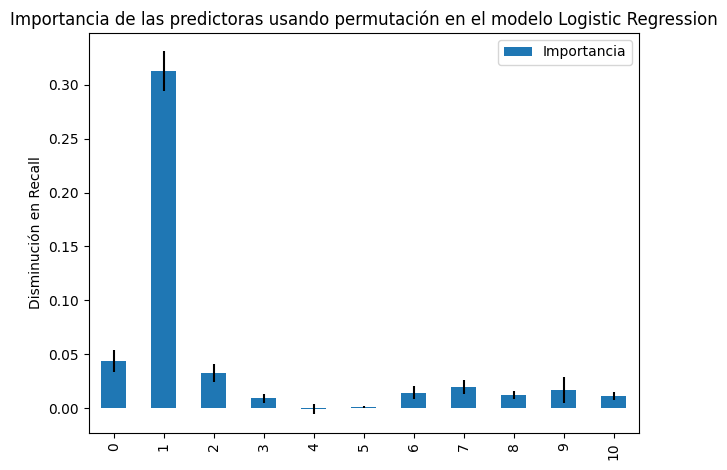

In [117]:
#Se crea un gráfico para visualizar los resultados
fig, ax = plt.subplots()
importancias_estimadores.plot.bar(yerr=importancia_resultados.importances_std, ax=ax)
ax.set_title("Importancia de las predictoras usando permutación en el modelo Logistic Regression")
ax.set_ylabel("Disminución en Recall")
fig.tight_layout()
plt.show()

###*Evaluación del mejor predictor con diferentes cantidades de features*

In [119]:
#Se ordenan las importancias de mayor a menor
importancias_estimadores.sort_values(by='Importancia', ascending=False, inplace=True)

In [124]:
#Se crea una función para calcular el promedio de las métricas de interés
def evaluarClasificacion(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1= f1_score(y_true, y_pred)
  evaluacion = {'accuracy':round(accuracy,4),
                'recall':round(recall,4),
                'precision':round(precision,4),
                'f1':round(f1,4)}
  return evaluacion

In [127]:
#Dataframe para alamcenar los resultados por cada variación en la cantidad de predictoras
df_resultados = pd.DataFrame(index=['accuracy', 'recall', 'precision', 'f1'])

#Iteración del 1 al 11. Siendo el primer elemento 1.
ct_features = [i if i != 0 else 1 for i in range(0,12,1)]

for cantidad in ct_features:
  #Selección de nombres de features según cantidad
  features_selected = importancias_estimadores['Predictora'][:cantidad].values
  #Filtrado del conjunto de entrenamiento y prueba con base a los nombres de los features seleccionados
  X_train_selected = X_train[features_selected]
  X_test_selected = X_test[features_selected]
  #Entrenamiento del modelo
  modelo.fit(X_train_selected, y_train)
  #Predicción de y para X_test (regresores de prueba)
  y_pred = modelo.predict(X_test_selected)
  #Evaluacion del modelo
  evaluacion = evaluarClasificacion(y_test, y_pred)
  #Almacenamiento de resultados
  df_resultados[cantidad] = evaluacion.values()

df_resultados

,1,2,3,4,5,6,7,8,9,10,11
accuracy,0.7318,0.6673,0.6910,0.6910,0.7128,0.7028,0.7043,0.7100,0.7128,0.7156,0.7147
recall,0.5330,0.7897,0.7861,0.7807,0.7701,0.7879,0.7843,0.7968,0.8111,0.8004,0.8004
precision,0.4959,0.4314,0.4532,0.4529,0.4752,0.4653,0.4666,0.4730,0.4764,0.4792,0.4782
f1,0.5137,0.5579,0.5750,0.5733,0.5878,0.5850,0.5851,0.5936,0.6003,0.5995,0.5987


###*Selección de mejores features y división de datos*
Se seleccionó los primeros 9 features, según su **importancia total de permutación**. Debido a que la última mejora significativa ocurre al añadir el noveno feature (variable predictora).

In [132]:
#Lista con el nombre de los features seleccionados
features_relevantes = importancias_estimadores['Predictora'][:9].values.tolist()

datos_seleccionados = datos_transformados[features_relevantes]
datos_seleccionados.shape[1]

9

In [133]:
X = datos_seleccionados
y = datos_transformados['onehotencoder__churn_Si']
#Se dividió los datos en conjunto de entrenamiento y de prueba. El parametro stratify asegura que la proporción de clases de "y" se mantenga en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

##**Optimización de los hiperparámetros**

##**Exportación del modelo campeón**

##**Interpretación y conclusiones**
###*Análisis de la importancia de las variables*
Abc
###*Conclusión*
Abc